In [113]:
import numpy
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder, LabelEncoder
import gower
from scipy import stats
from sklearn_extra.cluster import KMedoids
# plt.style.use('dark_background')
# sns.set_palette('Set2')
from IPython.core.display import display
sns.set(style='ticks', context='talk')



In [114]:
def correlation_ratio(categories, values):
    cat = pd.factorize(categories)[0]
    values = np.array(values)

    ssw = 0
    ssb = 0
    for i in np.unique(cat):
        subgroup = values[np.argwhere(cat == i).flatten()]
        ssw += np.sum((subgroup-np.mean(subgroup))**2)
        ssb += len(subgroup)*(np.mean(subgroup)-np.mean(values))**2

    return (ssb / (ssb + ssw))**.5

In [115]:
def get_cramers_v(contingency_table):
    """ variation of cramers v that adjusts for bias
    via using a smaller mean-squared error.
    It calculates and returns this statistic"""

    chi2, p, dof, expected = stats.chi2_contingency(contingency_table)
    number_of_obs = np.sum(contingency_table).sum()
    phi2 = chi2 / number_of_obs
    row, column = contingency_table.shape
    mini = min(row, column)-1

    cramers_v = np.sqrt(phi2 / mini)
    return cramers_v

In [116]:
sleep = pd.read_csv('../data/SleepStudyData.csv')

# Practice Storytelling from sleep dataset
* data retrieved from survey results of participants
Description of data

- Enough = Do you think that you get enough sleep?
- Hours = On average, how many hours of sleep do you get on a weeknight?
- PhoneReach = Do you sleep with your phone within arms reach?
- PhoneTime = Do you use your phone within 30 minutes of falling asleep?
- Tired = On a scale from 1 to 5, how tired are you throughout the day? (1 being not tired, 5 being very tired)
- Breakfast = Do you typically eat breakfast?


In [117]:
display(sleep.head())

,Enough,Hours,PhoneReach,PhoneTime,Tired,Breakfast
0,Yes,8.0,Yes,Yes,3,Yes
1,No,6.0,Yes,Yes,3,No
2,Yes,6.0,Yes,Yes,2,Yes
3,No,7.0,Yes,Yes,4,No
4,No,7.0,Yes,Yes,2,Yes


In [118]:
# check for missing values

print(sleep.shape)
print(sleep.isnull().sum())
print('\n')

# check whether any missing or error values
for col in sleep.columns.tolist():
    print(col, sleep[col].unique())

(104, 6)
Enough        0
Hours         2
PhoneReach    0
PhoneTime     0
Tired         0
Breakfast     0
dtype: int64


Enough ['Yes' 'No']
Hours [ 8.  6.  7.  4. 10.  9.  2.  5. nan]
PhoneReach ['Yes' 'No']
PhoneTime ['Yes' 'No']
Tired [3 2 4 5 1]
Breakfast ['Yes' 'No']


In [119]:
# check where missing values in sleep

missing_hours = sleep.loc[sleep['Hours'].isnull()]
print(sleep.isnull().sum() / len(sleep))

# decide to drop this missing values as its < 2% of total records
sleep.drop(missing_hours.index, inplace=True)
sleep.isnull().sum()

Enough        0.000000
Hours         0.019231
PhoneReach    0.000000
PhoneTime     0.000000
Tired         0.000000
Breakfast     0.000000
dtype: float64


Enough        0
Hours         0
PhoneReach    0
PhoneTime     0
Tired         0
Breakfast     0
dtype: int64

In [120]:
# check dtypes and see if any conversion needed
sleep.dtypes


Enough         object
Hours         float64
PhoneReach     object
PhoneTime      object
Tired           int64
Breakfast      object
dtype: object

Dtypes were checked to make sure there would not be any interference in future options with data.

Often I would convert object to string dtype but because intent of this notebook is storytelling and object dtype will
not disrupt other operations this will not be changed for now.

Next step is look at column distributions indvidually before proceeding wiht more eda operations

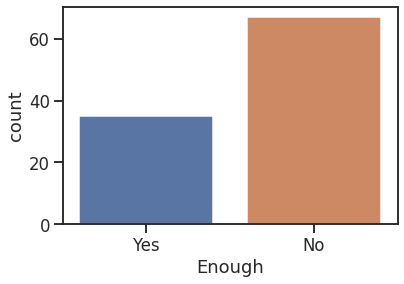

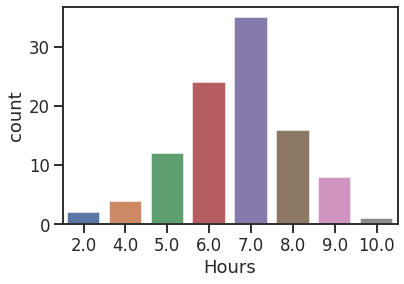

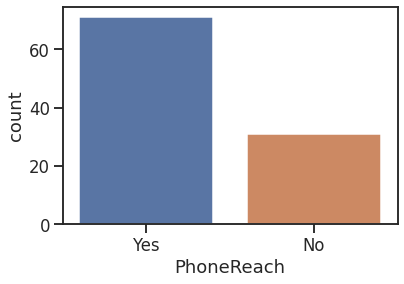

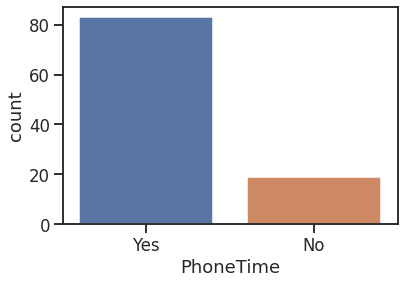

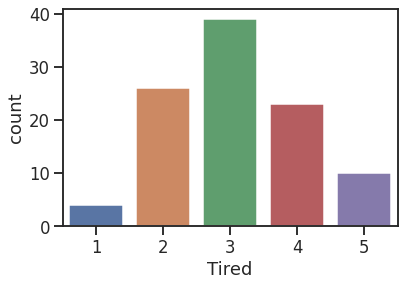

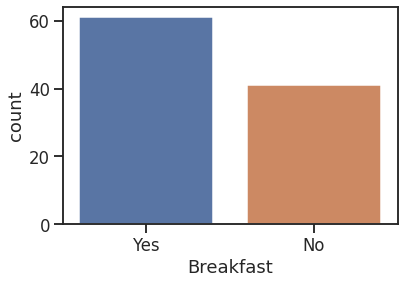

In [121]:
# make plots to show distribution of column data
sleep_columns = sleep.columns.tolist()

for col in sleep_columns:
    sns.countplot(data=sleep, x=col)
    plt.show()

* distribution viewing gives us a little bit context in our problem (?q question would there be a better way to present
this info in a more digestible manner rather than many countplots?) (perhaps do one plot of boxplots?)
* It appears that hours and tired have normal distributions
* whereas in the nominal columns we have some skew
* PhoneReach, PhoneTime, Breakfast tend to be yes whereas Enough sleep tend to be No

* go back to clustering example later.
* perform similarity and relation between enough sleep and nominal and numerical variables
* with nominal and numerical we can use eta coefficient test or point-biserial correlation
* with nominal and nominal we can use cramers v

* eta lets us know given a continuous value how well we can know which category it belongs to



In [122]:
# get numerical columns
num_columns = []
for col in sleep_columns:
    if sleep[col].dtype != 'object':
        num_columns.append(col)

# get categorical columns
cat_features = []
cat_columns = []
for col in sleep_columns:
    if sleep[col].dtype == 'object':
        cat_features.append(True)
        cat_columns.append(col)
    else:
        cat_features.append(False)

In [123]:
eta_coef_values = []
for col in num_columns:
    coef = correlation_ratio(sleep['Enough'], sleep[col])
    eta_coef_values.append(coef)
eta_coef_values

[0.3807397400354657, 0.41041604537669063]

In [124]:


cramers_v_values = []
for col in cat_columns[1:]:
    contingency_table = pd.crosstab(sleep['Enough'], sleep[col])
    cramers_v_values.append(get_cramers_v(contingency_table))
cramers_v_values

[0.038734791922842245, 0.0010400224772086771, 0.10818648779467475]

In [125]:
assoc_strengths = ['Strong', 'Moderate', 'Weak', 'Very weak']
cramers_strengths_values = [assoc_strengths[0] if val > 0.5 else
                          assoc_strengths[1] if val > 0.3 else
                          assoc_strengths[2] if val > 0.1 else
                          assoc_strengths[3] for val in cramers_v_values]
eta_strengths_values = [assoc_strengths[0] if val > 0.2 else
                          assoc_strengths[1] if val > 0.4 else
                          assoc_strengths[2] if val > 0.7 else
                          assoc_strengths[3] for val in eta_coef_values]

# assoc_strengths_values = cramers_strengths_values.append(eta_strengths_values)
# assoc_strengths_values

In [126]:
cramers_strengths_values
eta_strengths_values

['Strong', 'Strong']

In [127]:
features = cat_columns[1:] + num_columns
assoc_strengths_values = cramers_v_values + eta_coef_values
assoc_strengths = cramers_strengths_values + eta_strengths_values

sleep_relations = pd.DataFrame({
    'Sleep Features':features,
    'Cramers V & Eta Coef Scores':assoc_strengths_values,
    'Association Strength': assoc_strengths
}).sort_values(by='Cramers V & Eta Coef Scores', ascending=False)
sleep_relations

,Sleep Features,Cramers V & Eta Coef Scores,Association Strength
4,Tired,0.410416,Strong
3,Hours,0.380740,Strong
2,Breakfast,0.108186,Weak
0,PhoneReach,0.038735,Very weak
1,PhoneTime,0.001040,Very weak


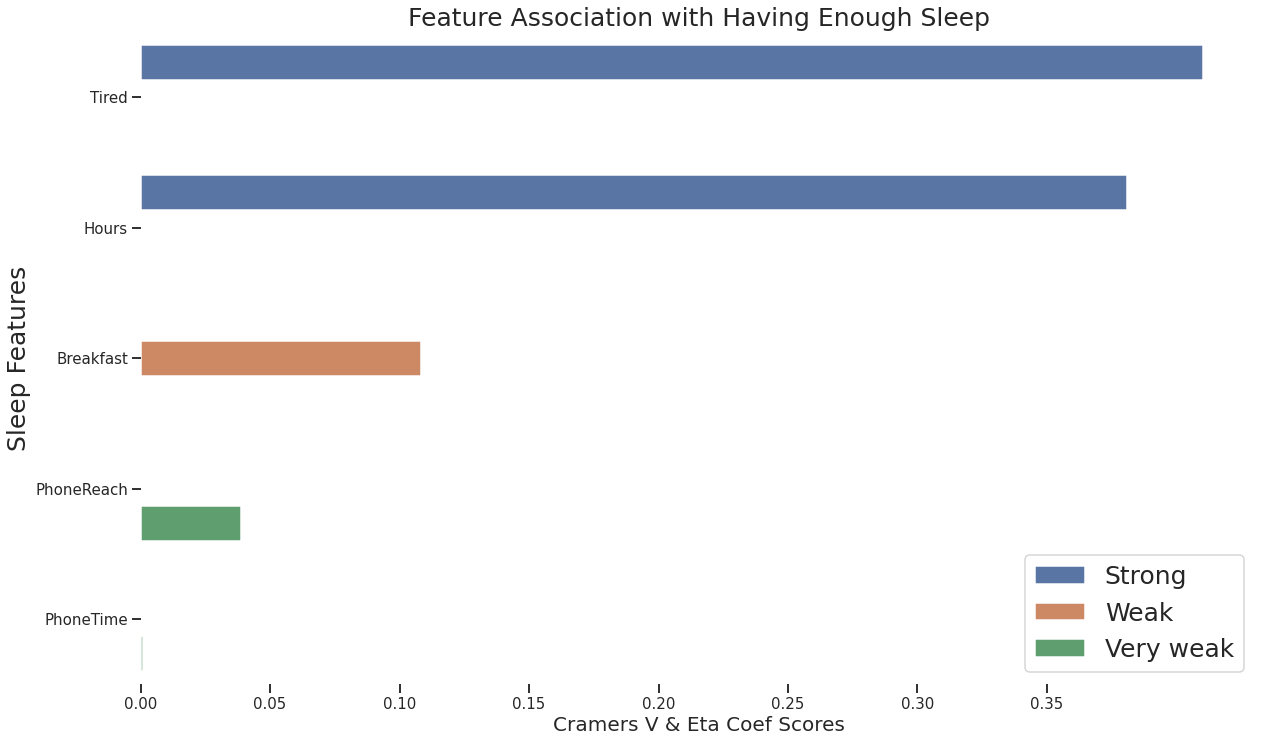

In [128]:
plt.figure(figsize=(20,12))
sns.barplot(data=sleep_relations, y='Sleep Features', x='Cramers V & Eta Coef Scores', hue='Association Strength')
sns.despine(left=True, bottom=True)
plt.title('Feature Association with Having Enough Sleep', fontsize=25)
plt.yticks(fontsize=15)
plt.xticks(np.arange(0, 0.4, 0.05), fontsize=15)
plt.xlabel('Cramers V & Eta Coef Scores', fontsize=20)
plt.ylabel('Sleep Features', fontsize=25)
plt.legend(fontsize=25, loc=4)

* seems obvious but number of hours of sleep had the most influence in determining whether an individual felt they
had enough sleep or not; along with how tired individuals felt throughout the day
* phone reach, and phone time before sleep did not seem to any influence towards feeling of getting ample amount of
sleep
* Breakfast appears to have a weak influence

Next need to visualize what info from strong associated features

<AxesSubplot:title={'center':'A Moderate score 3 and above often refers to not enough sleep'}, xlabel='count', ylabel='Tired'>

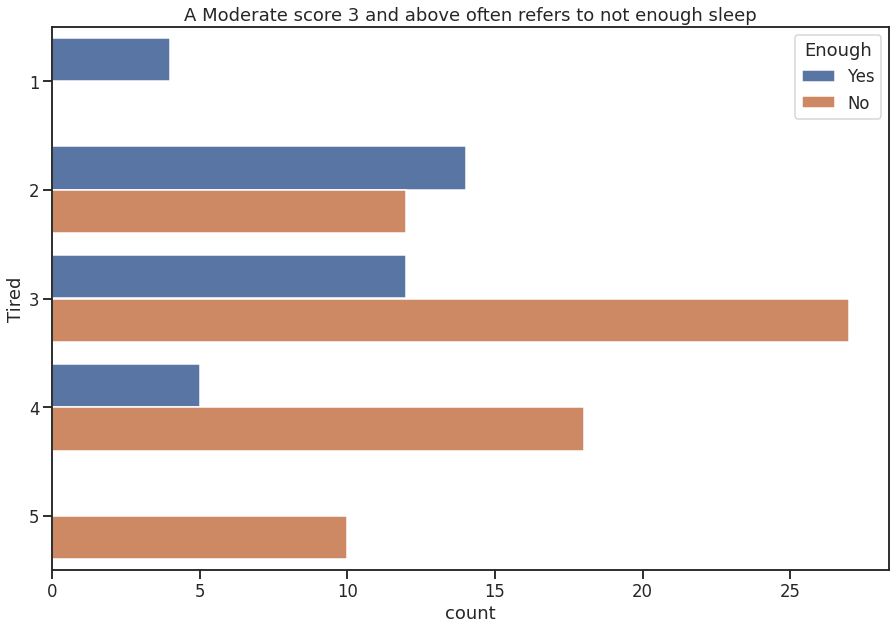

In [129]:
plt.figure(figsize=(15, 10))
plt.title('A Moderate score 3 and above often refers to not enough sleep')
sns.countplot(data=sleep, y='Tired', hue='Enough')

In [130]:
tired_enough = pd.crosstab(sleep['Enough'], sleep['Tired'], normalize='columns')
tired_enough

Tired,1,2,3,4,5
Enough,,,,,
No,0.0,0.461538,0.692308,0.782609,1.0
Yes,1.0,0.538462,0.307692,0.217391,0.0


* It appears that a tired score 3 and above for individuals feeling tired throughout the day, usually points to not
getting enough sleep (and perhaps leads to a cycle)
* Shows that scores of 3 and 4 have a ~70% of not enough sleep
* Shows that score of 5 being 100% not enough sleep

<AxesSubplot:title={'center':'Want to be less than 10 hours but more than 7 hours'}, xlabel='count', ylabel='Hours'>

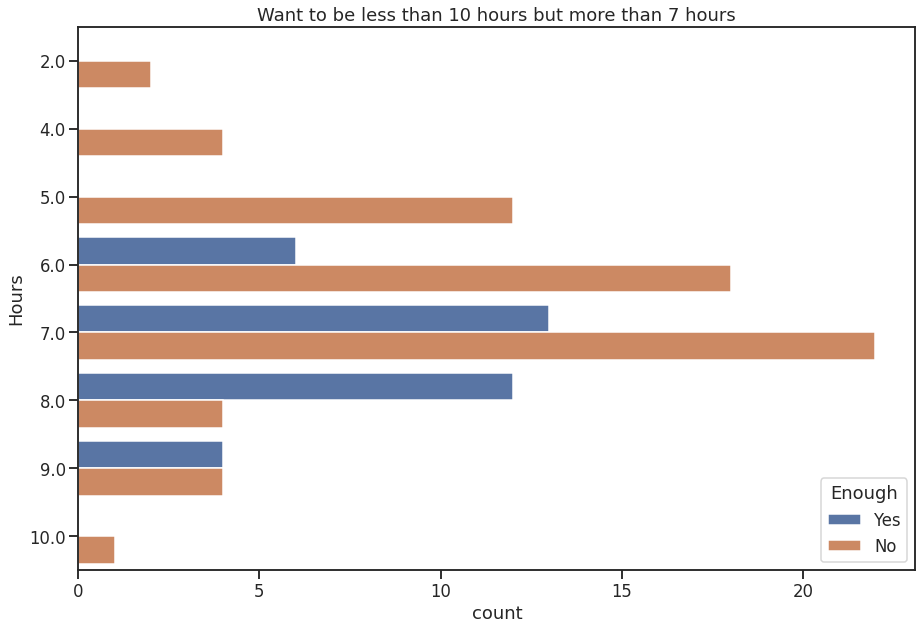

In [131]:
plt.figure(figsize=(15,10))
plt.title('Want to be less than 10 hours but more than 7 hours')
sns.countplot(data=sleep, y='Hours', hue='Enough')

In [132]:
hours_enough = pd.crosstab(sleep['Enough'], sleep['Hours'], normalize='columns')
hours_enough

Hours,2.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0
Enough,,,,,,,,
No,1.0,1.0,1.0,0.75,0.628571,0.25,0.5,1.0
Yes,0.0,0.0,0.0,0.25,0.371429,0.75,0.5,0.0


* It appears that we want to below 10 hours of sleep and greater than 7 hours of sleep for individuals to deem that
they have enough sleep
* Although I assume a 62% ratio of not enough sleep for 7 hours does not seem too bad


<AxesSubplot:title={'center':'Breakfast appears negligible to sleep but a little bit may help'}, xlabel='count', ylabel='Breakfast'>

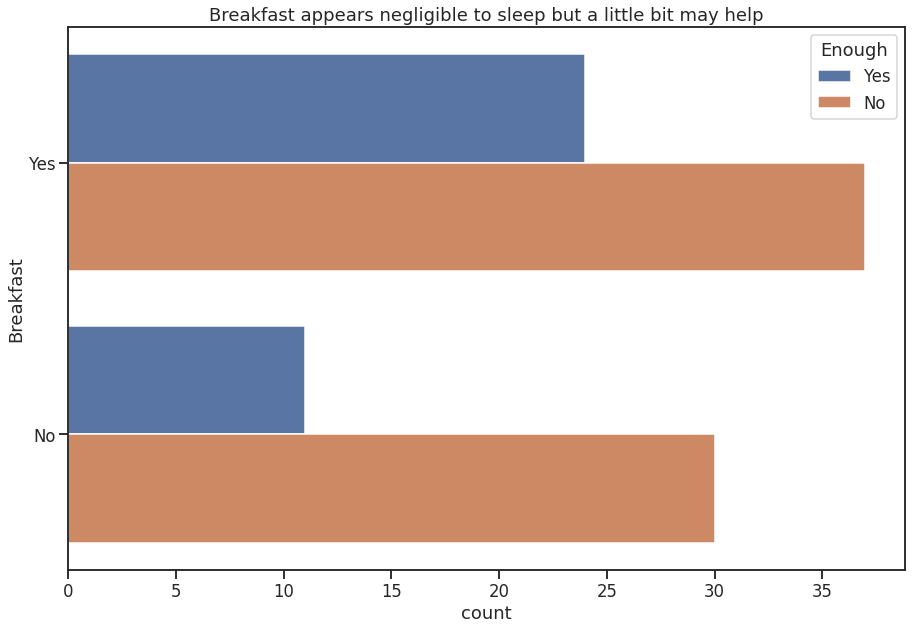

In [133]:
plt.figure(figsize=(15,10))
plt.title('Breakfast appears negligible to sleep but a little bit may help')
sns.countplot(data=sleep, y='Breakfast', hue='Enough')

In [134]:
breakfast_enough = pd.crosstab(sleep['Enough'], sleep['Breakfast'], normalize='columns')
breakfast_enough

Breakfast,No,Yes
Enough,,
No,0.731707,0.606557
Yes,0.268293,0.393443


* results between the two appear the same but perhaps a little breakfast would help. But a weak association often
explains that it would not matter match


## Clustering

Next will try to perform some clustering
* b/c our data is mixed types and not all continuous we cannot necessarily use kmeans clustering and need another
metric for distance
* we will use gower distance which is a metric that can be used to calculate the distance between two entities whose
attributes are a mix of categorical and quantitative values (distance is scaled between 0 and 1 range)

In [135]:
# perform clustering than perform correlation and cramers v
sleep
X = sleep
display(X)

y = X.iloc[0:1, :]
y

,Enough,Hours,PhoneReach,PhoneTime,Tired,Breakfast
0,Yes,8.0,Yes,Yes,3,Yes
1,No,6.0,Yes,Yes,3,No
2,Yes,6.0,Yes,Yes,2,Yes
3,No,7.0,Yes,Yes,4,No
4,No,7.0,Yes,Yes,2,Yes
...,...,...,...,...,...,...
99,No,7.0,Yes,Yes,2,Yes
100,No,7.0,No,Yes,3,Yes
101,Yes,8.0,Yes,Yes,3,Yes
102,Yes,7.0,Yes,Yes,2,Yes


,Enough,Hours,PhoneReach,PhoneTime,Tired,Breakfast
0,Yes,8.0,Yes,Yes,3,Yes


In [136]:


distance_matrix = gower.gower_matrix(X, cat_features=cat_features)
distance_matrix

array([[0.        , 0.375     , 0.08333334, ..., 0.        , 0.0625    ,
        0.04166667],
       [0.375     , 0.        , 0.375     , ..., 0.375     , 0.39583334,
        0.33333334],
       [0.08333334, 0.375     , 0.        , ..., 0.08333334, 0.02083333,
        0.04166667],
       ...,
       [0.        , 0.375     , 0.08333334, ..., 0.        , 0.0625    ,
        0.04166667],
       [0.0625    , 0.39583334, 0.02083333, ..., 0.0625    , 0.        ,
        0.0625    ],
       [0.04166667, 0.33333334, 0.04166667, ..., 0.04166667, 0.0625    ,
        0.        ]], dtype=float32)

* Gower distance interprets distance from row 1 to row 2 is .375 and distance from row 1 to row 3 is .083 etc..


{'icoord': [[15.0, 15.0, 25.0, 25.0],
  [45.0, 45.0, 55.0, 55.0],
  [35.0, 35.0, 50.0, 50.0],
  [85.0, 85.0, 95.0, 95.0],
  [75.0, 75.0, 90.0, 90.0],
  [65.0, 65.0, 82.5, 82.5],
  [42.5, 42.5, 73.75, 73.75],
  [105.0, 105.0, 115.0, 115.0],
  [58.125, 58.125, 110.0, 110.0],
  [20.0, 20.0, 84.0625, 84.0625],
  [125.0, 125.0, 135.0, 135.0],
  [145.0, 145.0, 155.0, 155.0],
  [130.0, 130.0, 150.0, 150.0],
  [175.0, 175.0, 185.0, 185.0],
  [195.0, 195.0, 205.0, 205.0],
  [225.0, 225.0, 235.0, 235.0],
  [215.0, 215.0, 230.0, 230.0],
  [200.0, 200.0, 222.5, 222.5],
  [180.0, 180.0, 211.25, 211.25],
  [165.0, 165.0, 195.625, 195.625],
  [140.0, 140.0, 180.3125, 180.3125],
  [265.0, 265.0, 275.0, 275.0],
  [295.0, 295.0, 305.0, 305.0],
  [285.0, 285.0, 300.0, 300.0],
  [315.0, 315.0, 325.0, 325.0],
  [292.5, 292.5, 320.0, 320.0],
  [345.0, 345.0, 355.0, 355.0],
  [335.0, 335.0, 350.0, 350.0],
  [306.25, 306.25, 342.5, 342.5],
  [270.0, 270.0, 324.375, 324.375],
  [255.0, 255.0, 297.1875, 297.187

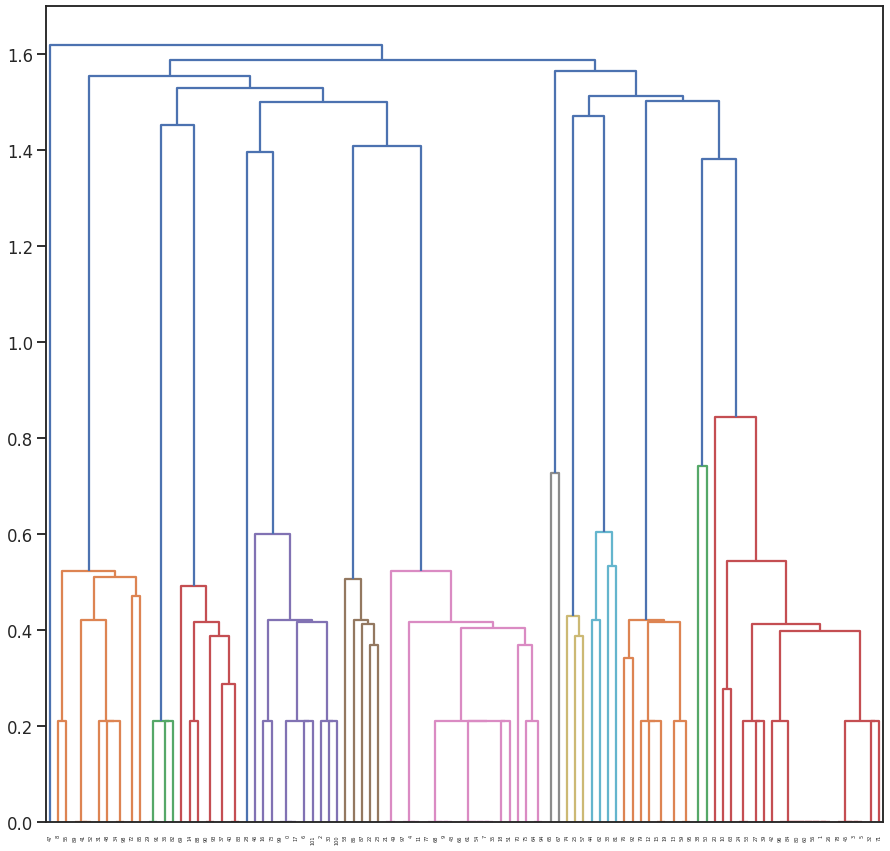

In [137]:
from scipy.cluster.hierarchy import linkage, fcluster, dendrogram
from scipy.cluster.hierarchy import ClusterWarning
from warnings import simplefilter
simplefilter("ignore", ClusterWarning)

Zd = linkage(distance_matrix)
plt.figure(figsize=(15,15))
dendrogram(Zd)


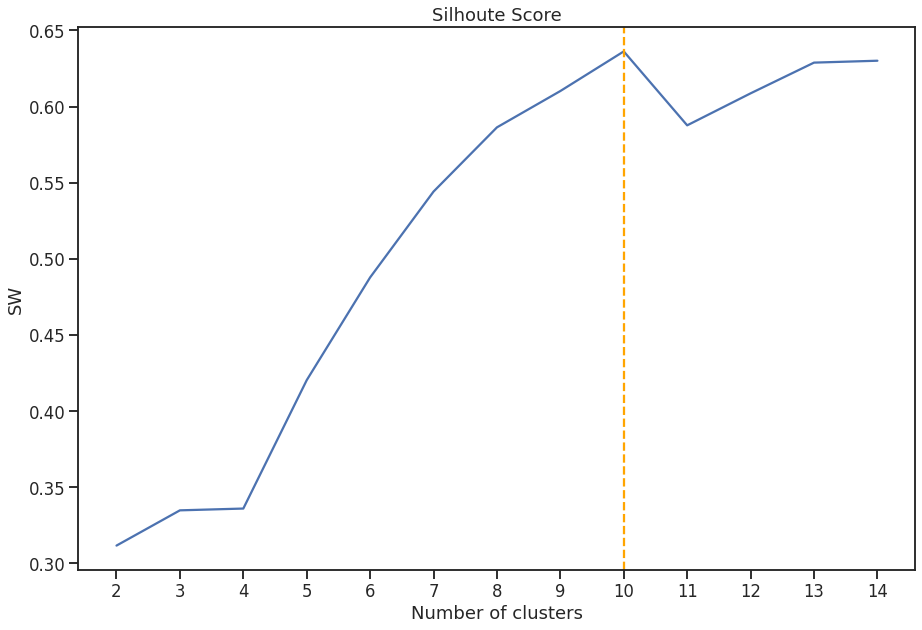

In [138]:
from sklearn.metrics import silhouette_score

# find number of clusters using silhouette widths
sw = []

for i in range(2, 15):
    kMedoids = KMedoids(n_clusters = i, metric='precomputed', method='pam', random_state = 42, init='k-medoids++')
    kMedoids.fit(distance_matrix)
    y_kmed = kMedoids.fit_predict(distance_matrix)
    silhouette_avg = silhouette_score(distance_matrix, y_kmed)
    sw.append(silhouette_avg)

# plot silhouette scores with number of clusters
plt.figure(figsize=(15,10))
plt.plot(range(2, 15), sw)
plt.title('Silhoute Score')
plt.xticks(np.arange(2,15))
plt.xlabel('Number of clusters')
plt.ylabel('SW')      #within cluster sum of squares
plt.axvline(x=10, linestyle='--', color='orange')
plt.show()

Similar to the dendrogram and silhouette avg scores point that clusters 10 suits our sleep data

In [139]:
# go with 10 clusters
kMedoids = KMedoids(n_clusters = 10, metric='precomputed', method='pam', random_state = 42, init='k-medoids++')
kMedoids.fit(distance_matrix)
kMedoids.fit_predict(distance_matrix)
kMedoids.labels_
y_kmed = kMedoids.fit_predict(distance_matrix)

In [140]:
kMedoids.inertia_ # Sum of distances of samples to their closest cluster center.


5.3125

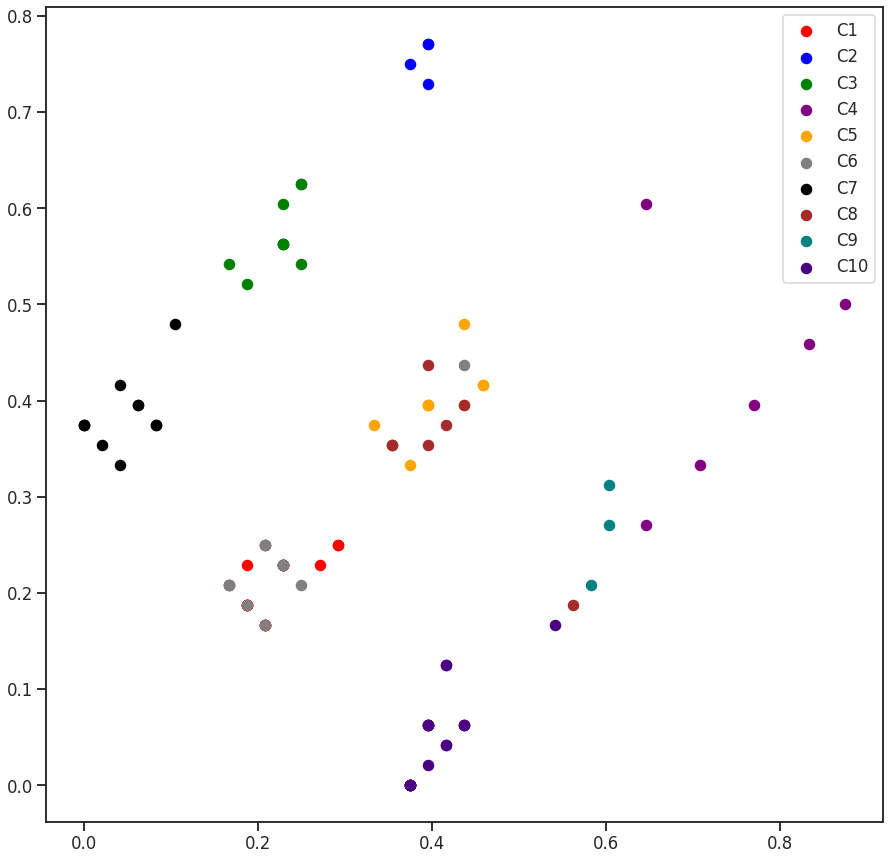

In [141]:
plt.figure(figsize=(15,15))
plt.scatter(distance_matrix[y_kmed == 0, 0], distance_matrix[y_kmed == 0, 1], s = 100, c = 'red', label = 'C1')
plt.scatter(distance_matrix[y_kmed == 1, 0], distance_matrix[y_kmed == 1, 1], s = 100, c = 'blue', label = 'C2')
plt.scatter(distance_matrix[y_kmed == 2, 0], distance_matrix[y_kmed == 2, 1], s = 100, c = 'green', label = 'C3')
plt.scatter(distance_matrix[y_kmed == 3, 0], distance_matrix[y_kmed == 3, 1], s = 100, c = 'purple', label = 'C4')
plt.scatter(distance_matrix[y_kmed == 4, 0], distance_matrix[y_kmed == 4, 1], s = 100, c = 'orange', label = 'C5')
plt.scatter(distance_matrix[y_kmed == 5, 0], distance_matrix[y_kmed == 5, 1], s = 100, c = 'grey', label = 'C6')
plt.scatter(distance_matrix[y_kmed == 6, 0], distance_matrix[y_kmed == 6, 1], s = 100, c = 'black', label = 'C7')
plt.scatter(distance_matrix[y_kmed == 7, 0], distance_matrix[y_kmed == 7, 1], s = 100, c = 'brown', label = 'C8')
plt.scatter(distance_matrix[y_kmed == 8, 0], distance_matrix[y_kmed == 8, 1], s = 100, c = 'teal', label = 'C9')
plt.scatter(distance_matrix[y_kmed == 9, 0], distance_matrix[y_kmed == 9, 1], s = 100, c = 'indigo', label = 'C10')
plt.legend()


* When plotting these clusters it appears that 10 is too many and 6-7 seems to be more appropriate
* Need to reevaluate plotting method in future
* Will stick with 10 clusters for now due to dendrograma and avg silhouette score pointing to 10 clusters

In [142]:
# Need to interpret clusters
sleep.insert(6, 'cluster number', kMedoids.labels_)
sleep

,Enough,Hours,PhoneReach,PhoneTime,Tired,Breakfast,cluster number
0,Yes,8.0,Yes,Yes,3,Yes,6
1,No,6.0,Yes,Yes,3,No,9
2,Yes,6.0,Yes,Yes,2,Yes,6
3,No,7.0,Yes,Yes,4,No,9
4,No,7.0,Yes,Yes,2,Yes,0
...,...,...,...,...,...,...,...
99,No,7.0,Yes,Yes,2,Yes,0
100,No,7.0,No,Yes,3,Yes,4
101,Yes,8.0,Yes,Yes,3,Yes,6
102,Yes,7.0,Yes,Yes,2,Yes,6


In [143]:
# need to find multivariate graph for this
display(sleep.loc[sleep['cluster number'] == 0])

,Enough,Hours,PhoneReach,PhoneTime,Tired,Breakfast,cluster number
4,No,7.0,Yes,Yes,2,Yes,0
7,No,7.0,Yes,Yes,3,Yes,0
9,No,6.0,Yes,Yes,3,Yes,0
11,No,7.0,Yes,Yes,2,Yes,0
18,No,9.0,Yes,Yes,3,Yes,0
21,No,4.0,Yes,Yes,2,Yes,0
35,No,7.0,Yes,Yes,3,Yes,0
43,No,6.0,Yes,Yes,3,Yes,0
49,No,4.0,Yes,Yes,2,Yes,0
51,No,8.0,Yes,Yes,3,Yes,0


### cluster 0
* Not enough sleep
* majority 7 hr sleepers with some straddlers (not the most predominant feature here)
* Yes Phone Reach
* Tired mostly 2-3 (very few 4 and 5)
* Yes Eat Breakfast

In [144]:
display(sleep.loc[sleep['cluster number'] == 1])

,Enough,Hours,PhoneReach,PhoneTime,Tired,Breakfast,cluster number
28,Yes,7.0,Yes,No,2,Yes,1
29,Yes,9.0,No,No,2,Yes,1
36,Yes,7.0,No,No,2,Yes,1
83,Yes,8.0,No,No,2,Yes,1
93,Yes,9.0,No,No,2,Yes,1


### cluster 1
* Enough Sleep
* 7+ hours of sleep (7-9)
* Yes phone close to them
* No phone time before sleep
* 2 Tiredness
* Eats Breakfast


In [145]:
display(sleep.loc[sleep['cluster number'] == 2])

,Enough,Hours,PhoneReach,PhoneTime,Tired,Breakfast,cluster number
14,Yes,7.0,No,Yes,3,Yes,2
37,Yes,9.0,No,Yes,2,Yes,2
40,Yes,8.0,No,Yes,1,Yes,2
70,Yes,6.0,No,Yes,4,Yes,2
84,Yes,8.0,No,Yes,1,Yes,2
89,Yes,8.0,No,Yes,3,Yes,2
92,Yes,7.0,No,Yes,2,Yes,2
95,Yes,7.0,No,Yes,2,Yes,2


### cluster 2
* Enough Sleep
* 6-8 hrs (majority 7-8)
* No phone close to them
* Yes phone time before sleep
* 1-4 tirediness (mainly 1-3)
* Eats Breakfast

In [146]:
display(sleep.loc[sleep['cluster number'] == 3])

,Enough,Hours,PhoneReach,PhoneTime,Tired,Breakfast,cluster number
33,No,6.0,No,No,3,No,3
38,No,5.0,Yes,No,5,No,3
44,No,4.0,No,No,5,No,3
47,No,5.0,No,No,5,Yes,3
62,No,2.0,No,No,5,No,3
82,No,5.0,No,No,4,No,3


### cluster 3
* Not enough Sleep
* 2-6 hrs (majority 4-6)
* Mainly No phone close to them
* No phone time before sleep
* 3-5 tirediness (mainly 5)
* Mainly No Breakfast


In [147]:
display(sleep.loc[sleep['cluster number'] == 4])

,Enough,Hours,PhoneReach,PhoneTime,Tired,Breakfast,cluster number
8,No,4.0,No,Yes,2,Yes,4
31,No,8.0,No,Yes,3,Yes,4
34,No,7.0,No,Yes,3,Yes,4
41,No,7.0,No,Yes,4,Yes,4
48,No,6.0,No,Yes,3,Yes,4
52,No,7.0,No,Yes,4,Yes,4
55,No,5.0,No,Yes,2,Yes,4
73,No,6.0,No,Yes,5,Yes,4
86,No,9.0,No,Yes,5,Yes,4
90,No,7.0,No,Yes,4,Yes,4


### cluster 4
* Not enough Sleep
* 4-9 hrs (majority 6,7)
* No phone close to them
* Yes phone time before sleep
* 2-5 tirediness (mainly 3-4)
* Eats Breakfast
* Maybe this groups works more so more tired throughtout day?


In [148]:
display(sleep.loc[sleep['cluster number'] == 5])

,Enough,Hours,PhoneReach,PhoneTime,Tired,Breakfast,cluster number
12,Yes,7.0,Yes,Yes,3,No,5
13,Yes,8.0,Yes,Yes,2,No,5
15,Yes,8.0,Yes,Yes,3,No,5
19,Yes,8.0,Yes,Yes,3,No,5
59,Yes,7.0,Yes,Yes,2,No,5
66,Yes,7.0,Yes,No,1,No,5
68,Yes,7.0,Yes,No,3,No,5
77,Yes,6.0,Yes,Yes,4,No,5
80,Yes,6.0,Yes,Yes,3,No,5
94,Yes,8.0,Yes,Yes,4,No,5


### cluster 5
* Enough Sleep
* 6-8 hrs (majority 7-8)
* Yes phone close to them
* Yes phone time before sleep
* 1-4 tirediness (mainly 2-3)
* No Breakfast

In [149]:
display(sleep.loc[sleep['cluster number'] == 6])

,Enough,Hours,PhoneReach,PhoneTime,Tired,Breakfast,cluster number
0,Yes,8.0,Yes,Yes,3,Yes,6
2,Yes,6.0,Yes,Yes,2,Yes,6
6,Yes,7.0,Yes,Yes,3,Yes,6
16,Yes,6.0,Yes,Yes,4,Yes,6
17,Yes,8.0,Yes,Yes,3,Yes,6
30,Yes,8.0,Yes,Yes,2,Yes,6
46,Yes,9.0,Yes,Yes,1,Yes,6
74,Yes,7.0,Yes,Yes,4,Yes,6
101,Yes,8.0,Yes,Yes,3,Yes,6
102,Yes,7.0,Yes,Yes,2,Yes,6


### cluster 6
* Enough Sleep
* 6-8 hrs (majority 7-8)
* Yes phone close to them
* Yes phone time before sleep
* 2-4 tirediness (mainly 2-3)
* Eat Breakfast

In [150]:
display(sleep.loc[sleep['cluster number'] == 7])

,Enough,Hours,PhoneReach,PhoneTime,Tired,Breakfast,cluster number
22,No,5.0,Yes,No,3,Yes,7
23,No,7.0,Yes,No,3,Yes,7
50,No,5.0,Yes,No,3,No,7
58,No,9.0,Yes,No,4,Yes,7
87,No,5.0,Yes,No,4,Yes,7
88,No,6.0,Yes,No,2,Yes,7


### cluster 7
* Not enough Sleep
* 5-9 hrs (majority 5-7)
* Yes phone close to them
* No phone time before sleep
* 2-4 tirediness (mainly 3-4)
* Eat Breakfast

In [151]:
display(sleep.loc[sleep['cluster number'] == 8])

,Enough,Hours,PhoneReach,PhoneTime,Tired,Breakfast,cluster number
25,No,7.0,No,Yes,5,No,8
57,No,9.0,No,Yes,5,No,8
75,No,6.0,No,Yes,4,No,8


### cluster 8
* Not enough Sleep
* 6-9 hrs
* No phone close to them
* Yes phone time before sleep
* 4-5 tirediness (mainly 2-3)
* No Breakfast
* Even with over 6hr sleep but still feel tired throughtout day

In [152]:
display(sleep.loc[sleep['cluster number'] == 9])

,Enough,Hours,PhoneReach,PhoneTime,Tired,Breakfast,cluster number
1,No,6.0,Yes,Yes,3,No,9
3,No,7.0,Yes,Yes,4,No,9
5,No,7.0,Yes,Yes,4,No,9
10,No,10.0,Yes,Yes,4,No,9
20,No,2.0,Yes,Yes,5,No,9
24,No,5.0,Yes,Yes,2,No,9
26,No,6.0,Yes,Yes,3,No,9
27,No,6.0,Yes,Yes,2,No,9
32,No,6.0,Yes,Yes,4,No,9
39,No,7.0,Yes,Yes,2,No,9


### cluster 9
* Not enough Sleep
* 2-10 hrs (majority 6-7)
* Yes phone close to them
* Yes phone time before sleep
* 2-5 tirediness (mainly 3-5)
* No Breakfast

In [155]:
# label encode 1 to yes and 0 to no
cat_columns
# this list can be used for inverset transformations
encoders = []
for col in cat_columns:
    le = LabelEncoder()
    sleep[col] = le.fit_transform(sleep[col])
    encoders.append(le)

sleep

,Enough,Hours,PhoneReach,PhoneTime,Tired,Breakfast,cluster number
0,1,8.0,1,1,3,1,6
1,0,6.0,1,1,3,0,9
2,1,6.0,1,1,2,1,6
3,0,7.0,1,1,4,0,9
4,0,7.0,1,1,2,1,0
...,...,...,...,...,...,...,...
99,0,7.0,1,1,2,1,0
100,0,7.0,0,1,3,1,4
101,1,8.0,1,1,3,1,6
102,1,7.0,1,1,2,1,6


In [158]:
sleep.groupby(by='cluster number').mean().round(2)

,Enough,Hours,PhoneReach,PhoneTime,Tired,Breakfast
cluster number,,,,,,
0,0.0,6.60,1.00,1.00,2.95,1.00
1,1.0,8.00,0.20,0.00,2.00,1.00
2,1.0,7.50,0.00,1.00,2.25,1.00
3,0.0,4.50,0.17,0.00,4.50,0.17
4,0.0,6.64,0.00,1.00,3.45,1.00
5,1.0,7.18,1.00,0.82,2.73,0.00
6,1.0,7.27,1.00,1.00,2.73,1.00
7,0.0,6.17,1.00,0.00,3.17,0.83
8,0.0,7.33,0.00,1.00,4.67,0.00


* From this chart it appears that
### Cluster 1
* Not enough sleep
* 6.6 hrs of sleep
* Has Phone Close
* Has Phone Time
* 2.95 Tired
* Eats Breakfast

### Cluster 2
* Enough sleep
* 8 hrs of sleep
* Most likely no phone reach
* No Phone Time
* 2 Tired
* Eats Breakfast

### Cluster 3
* Enough sleep
* 7.5 hrs of sleep
* No phone reach
* Has Phone Time
* 2.25 Tired
* Eats Breakfast

### Cluster 4
* Not enough sleep
* 4.5 hrs of sleep
* Mostly No phone reach
* No Phone Time
* 4.5 Tired
* Mostly No Breakfast

### Cluster 5
* Not enough sleep
* 6.64 hrs of sleep
* No phone reach
* Has Phone Time
* 3.45 Tired
* Eats Breakfast

### Cluster 6
* Enough sleep
* 7.18 hrs of sleep
* Has phone reach
* Moslty has Phone Time
* 2.73 Tired
* No Breakfast

### Cluster 7
* Enough sleep
* 7.27 hrs of sleep
* Has phone reach
* Has Phone Time
* 2.73 Tired
* Eats Breakfast

### Cluster 8
* Enough sleep
* 6.17 hrs of sleep
* Has phone reach
* No Phone Time
* 3.17 Tired
* Mostly Eat Breakfast

### Cluster 9
* Not enough sleep
* 7.33 hrs of sleep
* No phone reach
* Has Phone Time
* 4.67 Tired
* No Breakfast

### Cluster 10
* Not enough sleep
* 6.14 hrs of sleep
* Has phone reach
* Has Phone Time
* 3.33 Tired
* No Breakfast

## Evaluation
* Like the relation table it points that phone and proximity of your phone during sleep and phone time before sleep
has negligible effect on satisfaction of sleep
* Also eating breakfast has little effect
* But it is found that even with enough sleep over 6hrs would yield not feeling enough sleep if you feel tired
throughout most of the day, which may signify doing hard work throughout day (this is when not looking at avgs but overall
value distributions)
* Also vice versa where if you do work less tiring throughout rest of day you can sustain with less sleep
* But table points we need at least 7 hrs of sleep
